In [2]:
!pip install pandas numpy scikit-learn matplotlib seaborn

  Using cached scikit_learn-1.7.2-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached matplotlib-3.10.7-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
Using cached scikit_learn-1.7.2-cp313-cp313-win_amd64.whl (8.7 MB)
Using cached matplotlib-3.10.7-cp313-cp313-win_amd64.whl (8.1 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl (226 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)

   -------- ------------------------------- 1/5 [contourpy]
   -------- ------------------------------- 1/5 [contourpy]
   -------- ------------------------------- 1/5 [contourpy]
   -------- ------------------------------- 1/5 [contourpy]
   -------- ------------------------------- 1/5 [contourpy]
   -------- --------------------------


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [124]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib

In [125]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from matplotlib.ticker import FuncFormatter

In [126]:
# Load dataset
data = pd.read_csv("./datasets/data.csv")

In [127]:
# Display shape and preview
print("Shape:", data.shape)
print(data.head())

Shape: (4600, 18)
                  date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0  2014-05-02 00:00:00   313000.0       3.0       1.50         1340      7912   
1  2014-05-02 00:00:00  2384000.0       5.0       2.50         3650      9050   
2  2014-05-02 00:00:00   342000.0       3.0       2.00         1930     11947   
3  2014-05-02 00:00:00   420000.0       3.0       2.25         2000      8030   
4  2014-05-02 00:00:00   550000.0       4.0       2.50         1940     10500   

   floors  waterfront  view  condition  sqft_above  sqft_basement  yr_built  \
0     1.5           0     0          3        1340              0      1955   
1     2.0           0     4          5        3370            280      1921   
2     1.0           0     0          4        1930              0      1966   
3     1.0           0     0          4        1000           1000      1963   
4     1.0           0     0          4        1140            800      1976   

   yr_renovated     

In [128]:
# Check missing values
print(data.isnull().sum())

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64


In [129]:
# Remove duplicate rows
data = data.drop_duplicates()

# Fill missing numeric values with median
num_cols = data.select_dtypes(include=[np.number]).columns
data[num_cols] = data[num_cols].apply(lambda col: col.fillna(col.median()))

# Fill missing categorical values with mode (most frequent)
cat_cols = data.select_dtypes(include=['object', 'category']).columns
data[cat_cols] = data[cat_cols].apply(lambda col: col.fillna(col.mode()[0]) if not col.mode().empty else col)

# Clean unrealistic or invalid values (if columns exist)
if 'price' in data.columns:
    # Remove prices that are too small or too large
    data = data[(data['price'] > 10000) & (data['price'] < 1e8)]
if 'area' in data.columns:
    # Remove areas that are too small or too large
    data = data[(data['area'] > 10) & (data['area'] < 10000)]

# Optional: Reset index after cleaning
data = data.reset_index(drop=True)

print("✅ Data cleaned successfully!")
print(f"Remaining rows: {len(data)}")

✅ Data cleaned successfully!
Remaining rows: 4550


In [130]:
data = pd.get_dummies(data, drop_first=True)

In [131]:
if 'price' not in data.columns:
    raise KeyError("❌ 'price' column not found in dataset!")

X = data.drop(columns=['price'])
y = data['price']

In [132]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [133]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Data successfully prepared for training!")
print(f"🧩 X_train shape: {X_train_scaled.shape}")
print(f"🧩 X_test shape: {X_test_scaled.shape}")

✅ Data successfully prepared for training!
🧩 X_train shape: (3640, 4674)
🧩 X_test shape: (910, 4674)


In [134]:
results = []

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    results.append((name, r2, mae, rmse))

# Sort by R² descending
results.sort(key=lambda x: x[1], reverse=True)

print("\n🏆 Model Performance Comparison:")
for name, r2, mae, rmse in results:
    print(f"{name:20s} | R² = {r2:.4f} | MAE = {mae:,.2f} | RMSE = {rmse:,.2f}")


🏆 Model Performance Comparison:
XGBoost              | R² = 0.3806 | MAE = 112,880.19 | RMSE = 445,566.05
Random Forest        | R² = 0.3551 | MAE = 120,264.85 | RMSE = 454,640.45
Linear Regression    | R² = -0.2062 | MAE = 292,415.33 | RMSE = 621,754.84


In [135]:
best_model = XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42)
best_model.fit(X_train, y_train)


joblib.dump(best_model, "best_house_price_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(X.columns.tolist(), "feature_names.pkl")

['feature_names.pkl']

In [136]:
# === Train Model ===
best_model = XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42)
best_model.fit(X_train, y_train)

# === Save Model and Artifacts ===
joblib.dump(best_model, "best_house_price_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(X.columns.tolist(), "feature_names.pkl")

# === Example new house ===
new_house_data = {
    'bedrooms': 4,
    'bathrooms': 3,
    'sqft_living': 2500,
    'sqft_lot': 8000,
    'floors': 2.0,
    'waterfront': 0,
    'view': 0,
    'condition': 3,
    'sqft_above': 2500,
    'sqft_basement': 0,
    'yr_built': 2000,
    'yr_renovated': 0
}

# === Load Saved Items ===
loaded_model = joblib.load("best_house_price_model.pkl")
loaded_scaler = joblib.load("scaler.pkl")
feature_names = joblib.load("feature_names.pkl")

# === Prepare Input ===
new_house = pd.DataFrame([new_house_data])

# ✅ Add missing columns efficiently
missing_cols = [col for col in feature_names if col not in new_house.columns]
if missing_cols:
    # Create a DataFrame for all missing columns with zeros
    missing_df = pd.DataFrame(0, index=new_house.index, columns=missing_cols)
    # Concatenate all at once (avoids fragmentation)
    new_house = pd.concat([new_house, missing_df], axis=1)

# ✅ Match column order exactly
new_house = new_house[feature_names]

# === Scale & Predict ===
new_house_scaled = loaded_scaler.transform(new_house)
predicted_price = loaded_model.predict(new_house_scaled)

print(f"\n🏠 Predicted House Price: ${round(predicted_price[0], 2)}")


🏠 Predicted House Price: $208383.21875


C:\Users\Damim_X_Adi\AppData\Local\Temp\ipykernel_11912\1886251058.py:70: UserWarning: Glyph 127968 (\N{HOUSE BUILDING}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Damim_X_Adi\PycharmProjects\Master_AI_1st\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127968 (\N{HOUSE BUILDING}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


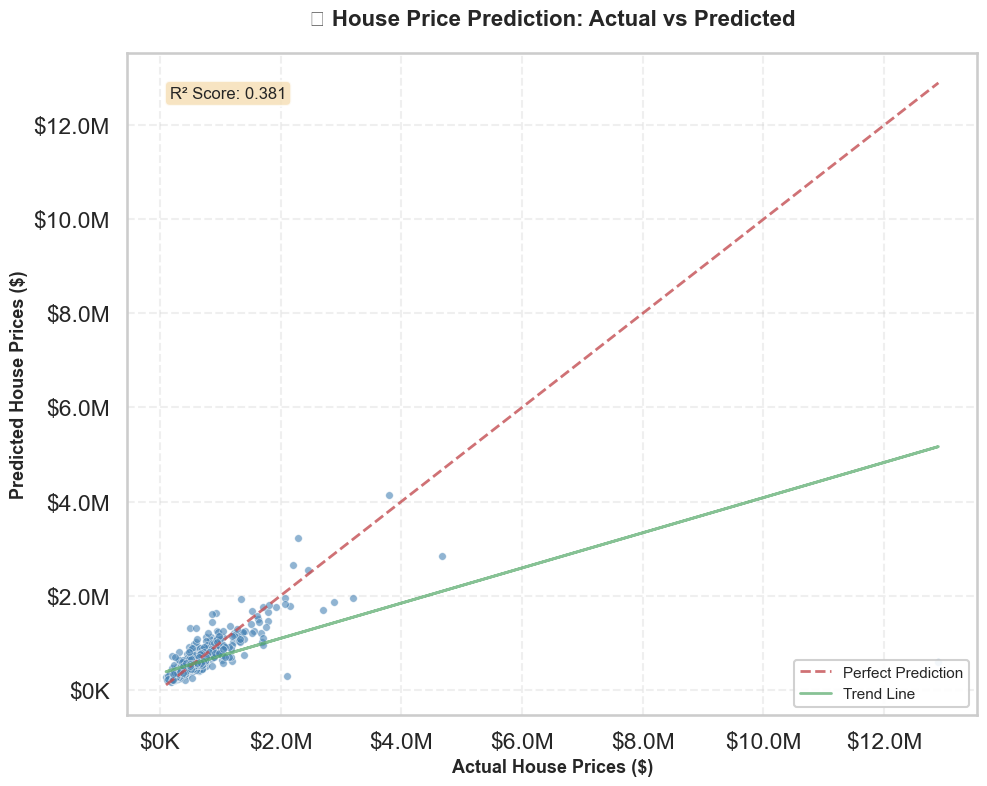

In [137]:
# Set high-quality figure parameters
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 11

# Create predictions
y_pred = best_model.predict(X_test)

# Calculate R² score for annotation
r2 = r2_score(y_test, y_pred)

# Create figure with better size
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot with better styling
scatter = ax.scatter(y_test, y_pred,
                     alpha=0.6,
                     s=30,
                     c='steelblue',
                     edgecolors='white',
                     linewidth=0.5)

# Perfect prediction line (y=x)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
ax.plot([min_val, max_val], [min_val, max_val],
        'r--',
        linewidth=2,
        label='Perfect Prediction',
        alpha=0.8)

# Add regression line
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
ax.plot(y_test, p(y_test),
        'g-',
        linewidth=2,
        label='Trend Line',
        alpha=0.7)

# Labels and title
ax.set_xlabel('Actual House Prices ($)', fontsize=13, fontweight='bold')
ax.set_ylabel('Predicted House Prices ($)', fontsize=13, fontweight='bold')
ax.set_title('🏠 House Price Prediction: Actual vs Predicted',
             fontsize=16,
             fontweight='bold',
             pad=20)

# Format axes with currency
ax.ticklabel_format(style='plain', axis='both')
def currency(x, pos):
    return f'${x/1e6:.1f}M' if x >= 1e6 else f'${x/1e3:.0f}K'
ax.xaxis.set_major_formatter(FuncFormatter(currency))
ax.yaxis.set_major_formatter(FuncFormatter(currency))

# Add R² score text box
textstr = f'R² Score: {r2:.3f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.05, 0.95, textstr,
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=props)

# Grid and legend
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='lower right', fontsize=11, framealpha=0.9)

# Tight layout for better spacing
plt.tight_layout()
plt.show()